# Universidad Internacional de La Rioja  

### Máster Universitario en Visual Analytics and Big Data  

---

### **Predicción y Análisis de la Demanda y Suministro de Productos entre la Comunidad Andina y España**  
**Presentado por:** Danilo Andrés Beleño Villafañe  

---

### **Notebook 5: Modelado - Proceso General**  


### Librerias

In [1]:
#!pip install pmdarima
#!pip install fastparquet
#!pip install keras_tuner
#!pip install tensorflow

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from keras import Input
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_percentage_error
from utils.bigquery_handler import BigQueryHandler

### Configuracion

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

bqh = BigQueryHandler('unir-predictiv0-andina-espana')

### Validacion estructura de datos

In [4]:
query = f"""
    SELECT 
        *
    FROM `unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo` 
    LIMIT 5
"""

data = bqh.get_bigquery_data(query)

data.head()

fecha  anio  mes tipo_movimiento_cod tipo_movimiento  \
0  2005-10-01  2005   10                   I     Importacion   
1  2005-10-01  2005   10                   I     Importacion   
2  2005-10-01  2005   10                   E     Exportacion   
3  2005-10-01  2005   10                   E     Exportacion   
4  2005-10-01  2005   10                   E     Exportacion   

  estado_transaccion cod_pais nombre_pais cod_provincia nombre_provincia  \
0         definitivo      480    Colombia            27             Lugo   
1         definitivo      500     Ecuador            24             León   
2         definitivo      504        Perú            24             León   
3         definitivo      500     Ecuador            24             León   
4         definitivo      500     Ecuador            42            Soria   

  cod_comunidad nombre_comunidad nivel_taric cod_taric  \
0            10          Galicia           3    620349   
1            06  Castilla y León           4  61101130   
2            06  Castilla y León           3    930621   
3            06  Castilla y León           4  49029090   
4            06  Castilla y León           3    130219   

                               descripcion_taric     euros   dolares  \
0                 De las demás materias textiles    358.53    430.77   
1      Suéteres "jerseys" (exc suéteres >= 50% )   1875.44   2253.34   
2  Cartuchos, escopet /rifle c/ cañón ánima lisa  38700.98  46499.23   
3   Diarios y publicaciones periódicas, impresos    322.08    386.98   
4                                      Los demás  27822.32  33428.52   

   kilogramos  
0         8.0  
1       371.0  
2     18000.0  
3        90.0  
4      1845.0

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fecha                5 non-null      dbdate 
 1   anio                 5 non-null      Int64  
 2   mes                  5 non-null      Int64  
 3   tipo_movimiento_cod  5 non-null      object 
 4   tipo_movimiento      5 non-null      object 
 5   estado_transaccion   5 non-null      object 
 6   cod_pais             5 non-null      object 
 7   nombre_pais          5 non-null      object 
 8   cod_provincia        5 non-null      object 
 9   nombre_provincia     5 non-null      object 
 10  cod_comunidad        5 non-null      object 
 11  nombre_comunidad     5 non-null      object 
 12  nivel_taric          5 non-null      object 
 13  cod_taric            5 non-null      object 
 14  descripcion_taric    5 non-null      object 
 15  euros                5 non-null      float64

In [6]:
data['fecha'] = pd.to_datetime(data['fecha'])
print(data.dtypes)

fecha                  datetime64[ns]
anio                            Int64
mes                             Int64
tipo_movimiento_cod            object
tipo_movimiento                object
estado_transaccion             object
cod_pais                       object
nombre_pais                    object
cod_provincia                  object
nombre_provincia               object
cod_comunidad                  object
nombre_comunidad               object
nivel_taric                    object
cod_taric                      object
descripcion_taric              object
euros                         float64
dolares                       float64
kilogramos                    float64
dtype: object


### Validacion por producto taric a nivel 1

In [7]:

query = f"""
    SELECT
        fecha,
        cod_taric,
        descripcion_taric,
        dolares,
        kilogramos
    FROM `unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo`
    WHERE nivel_taric = '1'
"""

data = bqh.get_bigquery_data(query)

data.head()

fecha cod_taric                 descripcion_taric   dolares  \
0  2005-10-01        58  Terciopelo; c/ bucles; tapicería     37.39   
1  2005-10-01        91                         Relojería   1624.31   
2  2005-10-01        05  Otros productos de origen animal   8494.61   
3  2005-10-01        14               Materias trenzables  12475.15   
4  2005-10-01        41      Pieles (exc peleter); cueros   1282.54   

   kilogramos  
0         1.5  
1        14.0  
2       126.0  
3      1160.0  
4         1.0

In [8]:
if data['fecha'].isna().any():
    print("La columna 'Fecha' contiene valores nulos.")
else:
    print("La columna 'Fecha' no tiene valores nulos.")

La columna 'Fecha' no tiene valores nulos.


In [9]:
df = (
    data.groupby(["fecha", "descripcion_taric"])
    .agg(kilogramos_sum=("kilogramos", "sum"))
    .reset_index()
)

df = df.pivot(index="fecha", columns="descripcion_taric", values=["kilogramos_sum"])

df.columns = ["_".join(col).strip() for col in df.columns.values]

df.reset_index(inplace=True)

df.head(5)


fecha  kilogramos_sum_Abonos  \
0  1995-01-01                    NaN   
1  1995-02-01                11193.0   
2  1995-03-01                41500.0   
3  1995-04-01                   22.0   
4  1995-05-01                14238.0   

   kilogramos_sum_Aceites esenciales; perfumer  \
0                                       9666.0   
1                                      23268.0   
2                                      78788.2   
3                                      21429.0   
4                                      46405.0   

   kilogramos_sum_Aeronaves; vehículos espaciales  \
0                                             NaN   
1                                           13.60   
2                                            4.36   
3                                            7.84   
4                                            8.40   

   kilogramos_sum_Alfombras; revesti textiles suelo  kilogramos_sum_Algodón  \
0                                             221.0                 34065.0   
1                                              56.0                 43800.0   
2                                             583.0                 69979.0   
3                                            5960.0                 77420.0   
4                                           10898.0                178440.1   

   kilogramos_sum_Aluminio y sus manufacturas  kilogramos_sum_Animales vivos  \
0                                       217.0                          310.0   
1                                       641.0                          921.0   
2                                      3059.0                          157.0   
3                                      2902.0                         3000.0   
4                                     16714.0                           90.0   

   kilogramos_sum_Aparatos y material eléctricos  \
0                                      696942.40   
1                                      322913.92   
2                                     1931986.40   
3                                      933047.22   
4                                     1532314.40   

   kilogramos_sum_Aparatos ópticos, medida, médicos  \
0                                           8839.50   
1                                          40580.40   
2                                          60836.80   
3                                          21865.88   
4                                          37828.58   

   kilogramos_sum_Armas y municiones; accesorios  \
0                                        10910.0   
1                                        20064.0   
2                                          302.0   
3                                          675.0   
4                                            NaN   

   kilogramos_sum_Artíc textilhogar; prendería  \
0                                     15308.00   
1                                     11663.00   
2                                     37013.90   
3                                     14991.62   
4                                     33874.62   

   kilogramos_sum_Artículos de sombrerería  \
0                                     58.0   
1                                    247.0   
2                                   3278.0   
3                                    186.0   
4                                   1543.0   

   kilogramos_sum_Azúcares; artículos confitería  \
0                                        68220.0   
1                                        52433.0   
2                                        86915.0   
3                                       140509.0   
4                                       132190.0   

   kilogramos_sum_Barcos y embarcaciones  \
0                                    NaN   
1                                    NaN   
2                                 2500.0   
3                                    NaN   
4                                    NaN   

   kilogramos_sum_Bebidas todo tipo (exc zumos)  \
0                          

In [10]:
null_percentage = (df.isna().sum() / df.shape[0]) * 100
print(null_percentage)

fecha                                                    0.000000
kilogramos_sum_Abonos                                    0.564972
kilogramos_sum_Aceites esenciales; perfumer              0.000000
kilogramos_sum_Aeronaves; vehículos espaciales           2.542373
kilogramos_sum_Alfombras; revesti textiles suelo         9.039548
kilogramos_sum_Algodón                                   0.000000
kilogramos_sum_Aluminio y sus manufacturas               0.282486
kilogramos_sum_Animales vivos                           11.299435
kilogramos_sum_Aparatos y material eléctricos            0.000000
kilogramos_sum_Aparatos ópticos, medida, médicos         0.000000
kilogramos_sum_Armas y municiones; accesorios            4.237288
kilogramos_sum_Artíc textilhogar; prendería              0.282486
kilogramos_sum_Artículos de sombrerería                  0.847458
kilogramos_sum_Azúcares; artículos confitería            0.000000
kilogramos_sum_Barcos y embarcaciones                   16.101695
kilogramos

In [11]:
numeric_columns = df.select_dtypes(include=['number']).columns
df[numeric_columns] = df[numeric_columns].fillna(0)

df.head()

fecha  kilogramos_sum_Abonos  \
0  1995-01-01                    0.0   
1  1995-02-01                11193.0   
2  1995-03-01                41500.0   
3  1995-04-01                   22.0   
4  1995-05-01                14238.0   

   kilogramos_sum_Aceites esenciales; perfumer  \
0                                       9666.0   
1                                      23268.0   
2                                      78788.2   
3                                      21429.0   
4                                      46405.0   

   kilogramos_sum_Aeronaves; vehículos espaciales  \
0                                            0.00   
1                                           13.60   
2                                            4.36   
3                                            7.84   
4                                            8.40   

   kilogramos_sum_Alfombras; revesti textiles suelo  kilogramos_sum_Algodón  \
0                                             221.0                 34065.0   
1                                              56.0                 43800.0   
2                                             583.0                 69979.0   
3                                            5960.0                 77420.0   
4                                           10898.0                178440.1   

   kilogramos_sum_Aluminio y sus manufacturas  kilogramos_sum_Animales vivos  \
0                                       217.0                          310.0   
1                                       641.0                          921.0   
2                                      3059.0                          157.0   
3                                      2902.0                         3000.0   
4                                     16714.0                           90.0   

   kilogramos_sum_Aparatos y material eléctricos  \
0                                      696942.40   
1                                      322913.92   
2                                     1931986.40   
3                                      933047.22   
4                                     1532314.40   

   kilogramos_sum_Aparatos ópticos, medida, médicos  \
0                                           8839.50   
1                                          40580.40   
2                                          60836.80   
3                                          21865.88   
4                                          37828.58   

   kilogramos_sum_Armas y municiones; accesorios  \
0                                        10910.0   
1                                        20064.0   
2                                          302.0   
3                                          675.0   
4                                            0.0   

   kilogramos_sum_Artíc textilhogar; prendería  \
0                                     15308.00   
1                                     11663.00   
2                                     37013.90   
3                                     14991.62   
4                                     33874.62   

   kilogramos_sum_Artículos de sombrerería  \
0                                     58.0   
1                                    247.0   
2                                   3278.0   
3                                    186.0   
4                                   1543.0   

   kilogramos_sum_Azúcares; artículos confitería  \
0                                        68220.0   
1                                        52433.0   
2                                        86915.0   
3                                       140509.0   
4                                       132190.0   

   kilogramos_sum_Barcos y embarcaciones  \
0                                    0.0   
1                                    0.0   
2                                 2500.0   
3                                    0.0   
4                                    0.0   

   kilogramos_sum_Bebidas todo tipo (exc zumos)  \
0                          

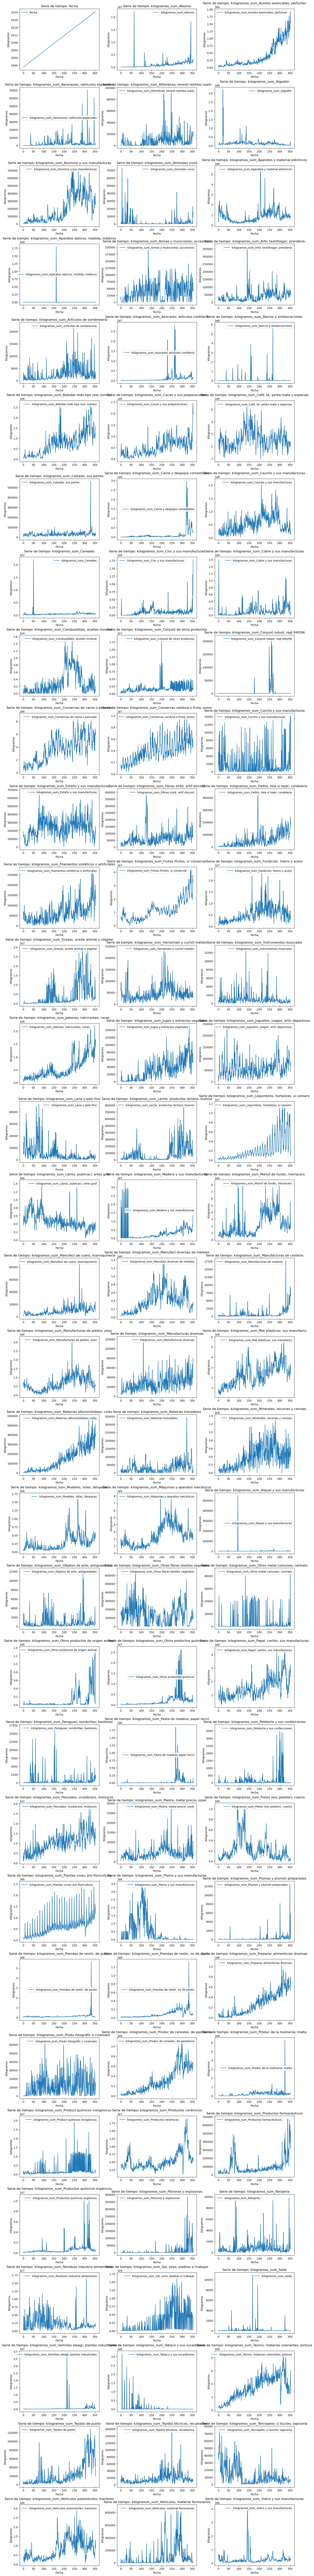

In [12]:
num_columns = 3
num_plots = len(df.columns)
num_rows = math.ceil(num_plots / num_columns)
fig, axes = plt.subplots(
    num_rows, num_columns, figsize=(15, num_rows * 4), constrained_layout=True
)
axes = axes.flatten()

for i, col in enumerate(df.columns):
    axes[i].plot(df.index, df[col], label=col)
    axes[i].set_title(f"Serie de tiempo: {col}")
    axes[i].set_xlabel("Fecha")
    axes[i].set_ylabel("Kilogramos")
    axes[i].legend()

for i in range(num_plots, len(axes)):
    fig.delaxes(axes[i])

plt.show()

del df

### Estructuracion de los datos

In [13]:
query = f"""
    SELECT 
        fecha,
        tipo_movimiento_cod,
        cod_pais,
        nombre_pais,
        nivel_taric,
        cod_taric,
        descripcion_taric,
        sum(dolares) as dolares,
        sum(kilogramos) as kilogramos
    FROM `unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo` 
    WHERE nivel_taric = '1'
    GROUP BY 1,2,3,4,5,6,7
"""

data = bqh.get_bigquery_data(query)
data['fecha'] = pd.to_datetime(data['fecha'])

data.head()

fecha tipo_movimiento_cod cod_pais nombre_pais nivel_taric cod_taric  \
0 2005-10-01                   I      500     Ecuador           1        89   
1 2017-09-01                   E      480    Colombia           1        67   
2 2017-09-01                   E      500     Ecuador           1        43   
3 2010-09-01                   I      504        Perú           1        14   
4 2003-09-01                   I      504        Perú           1        78   

              descripcion_taric     dolares  kilogramos  
0        Barcos y embarcaciones     2169.66     2300.00  
1    Plumas y plumón preparados      694.13      121.74  
2  Peletería y sus confecciones      377.44        9.00  
3           Materias trenzables    14882.99     9000.00  
4      Plomo y sus manufacturas  1285808.20  1963917.00

In [14]:
def check_columns(df, required_columns):
    missing_columns = [
        column for column in required_columns if column not in df.columns
    ]
    if missing_columns:
        raise ValueError(
            f"The DataFrame is missing the following columns: {missing_columns}"
        )
    else:
        print("The DataFrame contains all the required columns.")

In [15]:
def generate_target_values(df, target):
    required_columns = ["fecha", "tipo_movimiento_cod", "cod_pais", target]
    check_columns(df, required_columns)

    unique_dates = (
        df[["fecha"]].drop_duplicates().sort_values("fecha").reset_index(drop=True)
    )

    total_target_by_country = (
        df.groupby(["fecha", "cod_pais"])[target]
        .sum()
        .unstack(fill_value=0)
        .add_prefix(f"{target}_T_")
        .reset_index()
    )

    dfs = list()
    for tipo_movimiento in ["I", "E"]:
        data = (
            df[df["tipo_movimiento_cod"] == tipo_movimiento]
            .groupby(["fecha", "cod_pais"])[target]
            .sum()
            .unstack(fill_value=0)
            .add_prefix(f"{target}_{tipo_movimiento}_")
            .reset_index()
        )
        dfs.append(data)

        data = (
            df[df["tipo_movimiento_cod"] == tipo_movimiento]
            .groupby("fecha")[target]
            .sum()
            .rename(f"{target}_{tipo_movimiento}_GLOBAL")
            .reset_index()
        )
        dfs.append(data)

    result_df = unique_dates.merge(total_target_by_country, on="fecha", how="left")

    for df in dfs:
        result_df = result_df.merge(df, on="fecha", how="left")

    numeric_columns = result_df.select_dtypes(include=["number"]).columns
    result_df[numeric_columns] = result_df[numeric_columns].fillna(0)

    return result_df

In [16]:
generate_target_values(data, 'dolares').head(3)

The DataFrame contains all the required columns.


fecha  dolares_T_480  dolares_T_500  dolares_T_504  dolares_T_516  \
0 1995-01-01    30196482.48    13092733.24    20857372.05     7715333.95   
1 1995-02-01    39119266.62    22325139.33    22881736.74     2425193.36   
2 1995-03-01    39962424.96    27015607.59    45449699.04     2394522.82   

   dolares_I_480  dolares_I_500  dolares_I_504  dolares_I_516  \
0    13864052.77     8500822.24     9542087.75     1214969.00   
1    20009694.94    15862975.37     7030612.74      826383.74   
2    13100617.29    17719781.20    15869715.94      925948.37   

   dolares_I_GLOBAL  dolares_E_480  dolares_E_500  dolares_E_504  \
0       33121931.76    16332429.71     4591911.00     11315284.3   
1       43729666.79    19109571.68     6462163.96     15851124.0   
2       47616062.80    26861807.67     9295826.39     29579983.1   

   dolares_E_516  dolares_E_GLOBAL  
0     6500364.95       38739989.96  
1     1598809.62       43021669.26  
2     1468574.45       67206191.61

In [17]:
generate_target_values(data, 'kilogramos').head(3)

The DataFrame contains all the required columns.


fecha  kilogramos_T_480  kilogramos_T_500  kilogramos_T_504  \
0 1995-01-01      1.344224e+07        6879638.72       14925949.85   
1 1995-02-01      1.390348e+08       34489305.27       13014039.06   
2 1995-03-01      1.530578e+07       11190574.20       21470671.86   

   kilogramos_T_516  kilogramos_I_480  kilogramos_I_500  kilogramos_I_504  \
0        1161138.50      5.270181e+06        5141468.00        9274936.40   
1        1045211.00      1.313237e+08       28981670.27        6813231.95   
2         426350.27      5.809553e+06        8017947.00       16138951.75   

   kilogramos_I_516  kilogramos_I_GLOBAL  kilogramos_E_480  kilogramos_E_500  \
0          203363.0         1.988995e+07        8172063.72        1738170.72   
1          161746.0         1.672804e+08        7711027.69        5507635.00   
2          174061.0         3.014051e+07        9496226.56        3172627.20   

   kilogramos_E_504  kilogramos_E_516  kilogramos_E_GLOBAL  
0        5651013.45         957775.50          16519023.39  
1        6200807.11         883465.00          20302934.80  
2        5331720.11         252289.27          18252863.14

### Definicion de modelos

In [18]:
def fit_auto_arima_iterative(train, test):
    best_mape = float("inf")
    best_forecast = None
    best_future = None

    for seasonal in [True, False]:
        for m in [6, 12, 24]:  # Periodicidades comunes
            try:
                if seasonal == True:
                    model = auto_arima(
                        train,
                        m=m,
                        trace=False,
                        error_action="ignore",
                        suppress_warnings=True,
                    )
                else:
                    model = auto_arima(
                        train,
                        seasonal=seasonal,
                        trace=False,
                        error_action="ignore",
                        suppress_warnings=True,
                    )

                forecast = model.predict(n_periods=len(test))
                mape = mean_absolute_percentage_error(test, forecast)

                if mape < best_mape:
                    best_mape = mape
                    best_forecast = forecast
                    best_future = model.predict(n_periods=30)
            except Exception as e:
                print(f"Error con m={m}, seasonal={seasonal}: {e}")

    return best_forecast, best_future, best_mape


In [19]:
def fit_lstm_iterative(train, test, future_steps=6):

    best_mape = float("inf")
    best_forecast = None
    best_future = None

    for units in [50, 100, 150]:
        for epochs in [10, 20]:
            try:
                # Preprocesamiento
                train_reshaped = np.reshape(train, (len(train), 1, 1))
                test_reshaped = np.reshape(test, (len(test), 1, 1))

                # Crear y entrenar el modelo LSTM
                model = Sequential()
                model.add(Input(shape=(1, 1)))
                model.add(LSTM(units, activation="relu"))
                model.add(Dense(1))
                model.compile(optimizer="adam", loss="mean_squared_error")
                model.fit(
                    train_reshaped,
                    train_reshaped[:, 0, 0],
                    epochs=epochs,
                    batch_size=32,
                    verbose=0,
                )

                # Predicción sobre el conjunto de prueba
                forecast = model.predict(test_reshaped).flatten()
                mape = mean_absolute_percentage_error(test, forecast)

                # Actualizar el mejor modelo si el MAPE mejora
                if mape < best_mape:
                    best_mape = mape
                    best_forecast = forecast

                    # Predicción iterativa para el futuro
                    future_input = test_reshaped[
                        -1
                    ]  # Comienza con la última entrada de prueba
                    best_future = []
                    for _ in range(
                        future_steps
                    ):  # Generar las predicciones configuradas
                        future_pred = model.predict(
                            future_input.reshape(1, 1, 1)
                        ).flatten()[0]
                        best_future.append(future_pred)
                        # Actualizar la entrada futura con la predicción actual
                        future_input = np.array([[future_pred]])
            except Exception as e:
                print(f"Error con units={units}, epochs={epochs}: {e}")

    return np.array(best_forecast), np.array(best_future), best_mape


In [20]:
def fit_mlp_iterative(train, test, future_steps=6):
    best_mape = float("inf")
    best_forecast = None
    best_future = None

    for hidden_units in [(64,), (64, 32), (128, 64)]:
        for epochs in [10, 20]:
            try:
                # Preprocesamiento
                train_reshaped = train.reshape(-1, 1)
                test_reshaped = test.reshape(-1, 1)

                # Crear y entrenar el modelo MLP
                model = Sequential()
                model.add(Input(shape=(1,)))
                for units in hidden_units:
                    model.add(Dense(units, activation="relu"))
                model.add(Dense(1))
                model.compile(optimizer="adam", loss="mean_squared_error")
                model.fit(
                    train_reshaped,
                    train_reshaped,
                    epochs=epochs,
                    batch_size=32,
                    verbose=0,
                )

                # Predicción sobre el conjunto de prueba
                forecast = model.predict(test_reshaped).flatten()
                mape = mean_absolute_percentage_error(test, forecast)

                # Actualizar el mejor modelo si el MAPE mejora
                if mape < best_mape:
                    best_mape = mape
                    best_forecast = forecast

                    # Predicción iterativa para el futuro
                    future_input = test_reshaped[
                        -1
                    ]  # Comienza con la última entrada de prueba
                    best_future = []
                    for _ in range(
                        future_steps
                    ):  # Generar las predicciones configuradas
                        future_pred = model.predict(
                            future_input.reshape(1, -1)
                        ).flatten()[0]
                        best_future.append(future_pred)
                        # Actualizar la entrada futura con la predicción actual
                        future_input = np.array([future_pred]).reshape(1, -1)
            except Exception as e:
                print(f"Error con hidden_units={hidden_units}, epochs={epochs}: {e}")

    return np.array(best_forecast), np.array(best_future), best_mape


In [21]:
def plot_results(train, test, forecast, future, title):
    plt.figure(figsize=(10, 5))
    plt.plot(train, label="Entrenamiento", color="blue")
    plt.plot(
        range(len(train), len(train) + len(test)), test, label="Prueba", color="orange"
    )
    plt.plot(
        range(len(train), len(train) + len(forecast)),
        forecast,
        label=f"Predicción ({title})",
        color="green",
    )
    plt.plot(
        range(len(train) + len(test), len(train) + len(test) + len(future)),
        future,
        "--",
        label="Futuro",
        color="red",
    )
    plt.title(f"Resultados del modelo {title}")
    plt.legend()
    plt.show()

In [22]:
def plot_results_side_by_side(
    train,
    test,
    arima_forecast,
    arima_future,
    lstm_forecast,
    lstm_future,
    mlp_forecast,
    mlp_future,
    col,
):
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharey=True)
    models = [
        ("ARIMA", arima_forecast, arima_future),
        ("LSTM", lstm_forecast, lstm_future),
        ("MLP", mlp_forecast, mlp_future),
    ]

    for ax, (title, forecast, future) in zip(axes, models):
        ax.plot(train, label="Entrenamiento", color="blue")
        ax.plot(
            range(len(train), len(train) + len(test)),
            test,
            label="Prueba",
            color="orange",
        )
        ax.plot(
            range(len(train), len(train) + len(forecast)),
            forecast,
            label=f"Predicción ({title})",
            color="green",
        )
        ax.plot(
            range(len(train) + len(test), len(train) + len(test) + len(future)),
            future,
            "--",
            label="Futuro",
            color="red",
        )
        ax.set_title(f"Resultados del modelo {title} - {col}")
        ax.legend()

    plt.tight_layout()
    plt.show()

In [23]:
def train_models(df, charts=False, chart_type="side_by_side"):
    results_df = pd.DataFrame()
    columns = df.columns

    for col in columns:
        print(f"Inicia proceso variable: {col}")
        series_data = df[col].values

        if not np.issubdtype(series_data.dtype, np.number):
            print(f"Saltando columna {col} porque no es numérica.")
            continue

        train_size = int(len(series_data) * 0.8)
        train, test = series_data[:train_size], series_data[train_size:]

        try:
            arima_forecast, arima_future, arima_mape = fit_auto_arima_iterative(train, test)
            arima_mape = mean_absolute_percentage_error(test, arima_forecast)

            lstm_forecast, lstm_future, lstm_mape = fit_lstm_iterative(
                np.array(train), np.array(test)
            )
            lstm_mape = mean_absolute_percentage_error(test, lstm_forecast)

            mlp_forecast, mlp_future, mlp_mape = fit_mlp_iterative(
                np.array(train), np.array(test)
            )
            mlp_mape = mean_absolute_percentage_error(test, mlp_forecast)

            if charts:
                if chart_type == "side_by_side":
                    plot_results_side_by_side(
                        train,
                        test,
                        arima_forecast,
                        arima_future,
                        lstm_forecast,
                        lstm_future,
                        mlp_forecast,
                        mlp_future,
                        col,
                    )
                else:
                    plot_results(train, test, arima_forecast, arima_future, f"ARIMA - {col}")
                    plot_results(train, test, lstm_forecast, lstm_future, f"LSTM - {col}")
                    plot_results(train, test, mlp_forecast, mlp_future, f"MLP - {col}")

            forecast_df = pd.DataFrame(
                {
                    "FORECAST_LEVEL": [
                        "MAPE",
                        "Forecast_1",
                        "Forecast_2",
                        "Forecast_3",
                        "Forecast_4",
                        "Forecast_5",
                        "Forecast_6",
                    ],
                    "ARIMA": [arima_mape] + arima_future[:6].tolist(),
                    "LSTM": [lstm_mape] + lstm_future[:6].tolist(),
                    "MLP": [mlp_mape] + mlp_future[:6].tolist(),
                }
            )
            forecast_df["Producto"] = col
            results_df = pd.concat([results_df, forecast_df], ignore_index=True)
        except Exception as e:
            print(f"Error al procesar {col}: {e}")
        print(f"Finaliza proceso variable: {col}")

    return results_df


In [24]:
def restructure_result(results):
    results[['llave1', 'llave2', 'llave3']] = results['Producto'].str.split('_', expand=True).fillna('N/A')
    results = pd.melt(
        results,
        id_vars=['FORECAST_LEVEL', 'Producto', 'llave1','llave2', 'llave3'],
        value_vars=['ARIMA', 'LSTM', 'MLP'],
        var_name='modelo',
        value_name='prediccion'
    )
    results['fecha_prediccion'] = pd.Timestamp.now()

    mape = results[results['FORECAST_LEVEL'] == 'MAPE']

    forecast_dates = {
        "Forecast_1": "2024-07-01",
        "Forecast_2": "2024-08-01",
        "Forecast_3": "2024-09-01",
        "Forecast_4": "2024-10-01",
        "Forecast_5": "2024-11-01",
        "Forecast_6": "2024-12-01",
    }
    results['fecha'] = pd.to_datetime(results['FORECAST_LEVEL'].map(forecast_dates))
    forecast = results[results['FORECAST_LEVEL'] != 'MAPE']
    return forecast, mape

### Entrenamiento

In [ ]:

for target in ['dolares']:
    print(f"Procesando target: {target}")
    df = generate_target_values(data, target)
    #results = train_models(df[['fecha', df.columns[1]]], charts=False)
    results = train_models(df, charts=False)
    forecast, mape = restructure_result(results)

    bqh.create_or_replace_table(
        dataset_id = 'datacomex',
        table_id = 'comex_comunidad_andina_forecast',
        dataframe = forecast,
        write_disposition="WRITE_APPEND"
    )

    bqh.create_or_replace_table(
        dataset_id = 'datacomex',
        table_id = 'comex_comunidad_andina_mape',
        dataframe = mape,
        write_disposition="WRITE_APPEND"
    )

Procesando target: dolares
The DataFrame contains all the required columns.
Inicia proceso variable: fecha
Saltando columna fecha porque no es numérica.
Inicia proceso variable: dolares_T_480
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/stepWARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024080D6E020> triggered tf.function retracing. Tracing 